# R&D CUPAC CUPED Wald estimator

## Генерация данных

In [23]:
import pandas as pd
import numpy as np
import time
from functools import wraps
from data_gen import DataGenerator

import warnings
warnings.filterwarnings("ignore")

Нормальные X и y, слабые корреляции

In [24]:
gen1 = DataGenerator(
    n_samples=2000,
    distributions={
        "X1": {"type": "normal", "mean": 0, "std": 1},
        "X2": {"type": "bernoulli", "p": 0.5},
        "y0": {"type": "normal", "mean": 5, "std": 1},
    },
    time_correlations={"X1": 0.2, "X2": 0.1, "y0": 0.3},
    effect_size=2.0,
    seed=7
)
df1 = gen1.generate()

Высокая автокорреляция и гамма-распределение для Y

In [25]:
gen2 = DataGenerator(
    n_samples=2000,
    distributions={
        "X1": {"type": "normal", "mean": 1, "std": 2},
        "X2": {"type": "bernoulli", "p": 0.3},
        "y0": {"type": "gamma", "shape": 2.0, "scale": 3.0},
    },
    time_correlations={"X1": 0.8, "X2": 0.4, "y0": 0.9},
    effect_size=3.0,
    seed=7
)
df2 = gen2.generate()

Сильно смещенное распределение X1 и слабый эффект

In [26]:
gen3 = DataGenerator(
    n_samples=3000,
    distributions={
        "X1": {"type": "normal", "mean": 10, "std": 5},
        "X2": {"type": "bernoulli", "p": 0.7},
        "y0": {"type": "normal", "mean": 0, "std": 1},
    },
    time_correlations={"X1": 0.5, "X2": 0.4, "y0": 0.6},
    effect_size=0.5,
    seed=7
)
df3 = gen3.generate()

Сильный эффект и Bernoulli-переменные

In [27]:
gen4 = DataGenerator(
    n_samples=1500,
    distributions={
        "X1": {"type": "bernoulli", "p": 0.2},
        "X2": {"type": "bernoulli", "p": 0.6},
        "y0": {"type": "normal", "mean": 3, "std": 2},
    },
    time_correlations={"X1": 0.2, "X2": 0.5, "y0": 0.4},
    effect_size=7.0,
    seed=7
)
df4 = gen4.generate()

Гамма Y, нормальный X1, умеренный эффект

In [28]:
gen5 = DataGenerator(
    n_samples=2500,
    distributions={
        "X1": {"type": "normal", "mean": 0, "std": 3},
        "X2": {"type": "bernoulli", "p": 0.5},
        "y0": {"type": "gamma", "shape": 5.0, "scale": 1.0},
    },
    time_correlations={"X1": 0.3, "X2": 0.2, "y0": 0.85},
    effect_size=4.0,
    seed=7
)
df5 = gen5.generate()

Малый эффект при нормальных X и Y

In [29]:
gen6 = DataGenerator(
    n_samples=5000,
    distributions={
        "X1": {"type": "normal", "mean": -1, "std": 1},
        "X2": {"type": "normal", "mean": 4, "std": 1},
        "y0": {"type": "normal", "mean": 8, "std": 2},
    },
    time_correlations={"X1": 0.4, "X2": 0.3, "y0": 0.9},
    effect_size=0.5,
    seed=7
)
df6 = gen6.generate()


Гамма-распределённые X и Y (тяжёлые хвосты)

In [30]:
gen7 = DataGenerator(
    n_samples=2000,
    distributions={
        "X1": {"type": "gamma", "shape": 2, "scale": 1},
        "X2": {"type": "normal", "mean": 3, "std": 1},
        "y0": {"type": "gamma", "shape": 2, "scale": 2},
    },
    time_correlations={"X1": 0.5, "X2": 0.5, "y0": 0.6},
    effect_size=4.0,
    seed=7
)
df7 = gen7.generate()

Очень высокая автокорреляция Y (практически консервативная метрика)

In [31]:
gen8 = DataGenerator(
    n_samples=4000,
    distributions={
        "X1": {"type": "normal", "mean": 0, "std": 1},
        "X2": {"type": "bernoulli", "p": 0.5},
        "y0": {"type": "normal", "mean": 10, "std": 1},
    },
    time_correlations={"X1": 0.2, "X2": 0.2, "y0": 0.95},
    effect_size=1.5,
    seed=7
)
df8 = gen8.generate()

In [32]:
dfs = [
    df.drop(columns=['y0', 'z', 'U', 'D', 'y1'])
    for df in [df1, df2, df3, df4, df5, df6, df7, df8]
]

In [33]:
dfs[0]

,X1,X1_lag,X2,X2_lag,y0_lag_1,y0_lag_2,d,y
0,-1.014791,-1.604160,0,0,4.058503,4.800092,1,7.127424
1,-0.283158,0.232314,1,1,5.436999,6.863391,1,4.824422
2,0.609791,0.612404,1,0,3.760400,5.603602,1,2.880424
3,1.110475,-1.109095,0,1,4.842997,4.502296,1,5.379159
4,-1.168063,-0.408486,0,0,5.898899,6.235804,0,4.828901
...,...,...,...,...,...,...,...,...
1995,-0.827531,0.758988,1,1,4.732813,3.751596,0,4.014402
1996,-2.404596,-0.981092,0,0,6.181040,4.124538,1,8.708952
1997,-0.094702,0.415405,1,0,3.955750,5.582502,0,4.909073
1998,-1.389898,-0.108940,0,1,4.534923,3.228373,0,2.082938


## Метрики сравнения реализаций CUPAC и CUPED

| **Критерий**                      | **Метрика**                                    |
|----------------------------------|-----------------------------------------------------|
| **ATE** | Должна быть одинаковой у всех корректных реализаций |
| **Standard Error (SE)**           | CUPAC должен её уменьшать                           |
| **Доверительный интервал (CI)**   | Чем уже — тем лучше                                 |
| **p-value**                       | CUPAC должен снижать p-value при одинаковом эффекте |
| **Время выполнения**              | Особенно важно при больших объёмах                  |

In [34]:
GLOBAL_RESULTS = pd.DataFrame(columns=[
    "experiment", "df",
    "control mean", "test mean", "difference",
    "ate ci lower", "ate ci upper", "ate ci delt", "p-value", 
    "base control mean", "base test ate", "control means diff", "test means diff",
    "execution time (sec)"
])

def log_execution_time(func):
    @wraps(func)
    def wrapper(self, df, *args, **kwargs):
        start = time.time()
        result = func(self, df, *args, **kwargs)
        self.execution_time = time.time() - start
        return result
    return wrapper

## Модели

### HypEx

In [35]:
from hypex import ABTest
from hypex.dataset import Dataset, InfoRole, TargetRole, TreatmentRole

class HypExExperiment:
    def __init__(self):
        self.name = 'HypEx'
        self.counter = 1
        self.result = None
        self.execution_time = None
        self.base_control_mean = None
        self.base_test_mean = None

    @log_execution_time
    def execute(self, df: pd.DataFrame):
        data = Dataset(
            roles={
                "d": TreatmentRole(),
                "y": TargetRole(),
            },
            data=df,
            default_role=InfoRole()
        )

        test = ABTest()
        self.result = test.execute(data)
        return self.result

    def full_execute(self, df):
        base = HypExExperiment().execute(df).resume.data.iloc[0]
        self.base_control_mean = base["control mean"]
        self.base_test_mean = base["test mean"]
        self.execute(df)

    def save_result(self):
        global GLOBAL_RESULTS
        if self.result is None:
            return

        row = self.result.resume.data.iloc[0]
        t_stat = self.result._experiment_data.analysis_tables['TTest┴┴y'].data['statistic'].iloc[0]
        SE = abs(row["difference"] / t_stat)
        ci_lower = row["difference"] - 1.9599611504231855 * SE
        ci_upper = row["difference"] + 1.9599611504231855 * SE
        summary = {
            "experiment": self.name,
            "df": f"df{self.counter}",
            "control mean": row["control mean"],
            "test mean": row["test mean"],
            "difference": row["difference"],
            "ate ci lower": ci_lower,
            "ate ci upper": ci_upper,
            "p-value": row["TTest p-value"],
            "base control mean": self.base_control_mean,
            "base test ate": self.base_test_mean,
            "control means diff": row["control mean"] - self.base_control_mean,
            "test means diff": row["test mean"] - self.base_test_mean,
            "execution time (sec)": self.execution_time
        }

        GLOBAL_RESULTS = pd.concat([GLOBAL_RESULTS, pd.DataFrame([summary])], ignore_index=True)
        self.counter += 1
        

### AutoCUPAC + HypEx

In [36]:
from autocupac import CUPACTransformer
from hypex import ABTest
from hypex.dataset import Dataset, InfoRole, TargetRole, TreatmentRole

class CupacHypExExperiment(HypExExperiment):
    def __init__(self):
        self.name = 'HypExCupac'
        self.counter = 1
        self.result = None
        self.execution_time = None

    @log_execution_time
    def execute(self, df: pd.DataFrame):
        transformer = CUPACTransformer(target_col='y')
        transformer.fit(df)
        transformed_data = transformer.transform(df)

        transformed_data = transformed_data.drop(columns=['y'])
        transformed_data = transformed_data.rename(columns={'y_cupac': 'y'})

        data = Dataset(
            roles={
                "d": TreatmentRole(),
                "y": TargetRole(),
            },
            data=transformed_data,
            default_role=InfoRole()
        )

        test = ABTest()
        self.result = test.execute(data)

### ambrosia + HypEx

In [37]:
from ambrosia.preprocessing import MultiCuped
from hypex import ABTest
from hypex.dataset import Dataset, InfoRole, TargetRole, TreatmentRole

class AmbrosiaCupacExperiment(HypExExperiment):
    def __init__(self):
        self.name = 'AmbrosiaCupac_HypEx'
        self.counter = 1
        self.result = None
        self.execution_time = None

    @log_execution_time
    def execute(self, df: pd.DataFrame):
        cuped = MultiCuped(verbose=False)
        cuped.fit(
                df,
                'y',
                ["X1_lag", "X2_lag", "y0_lag_1", "y0_lag_2"])
        transformed_data = cuped.transform(df)

        transformed_data = transformed_data.drop(columns=['y'])
        transformed_data = transformed_data.rename(columns={'y_transformed': 'y'})

        data = Dataset(
            roles={
                "d": TreatmentRole(),
                "y": TargetRole(),
            },
            data=transformed_data,
            default_role=InfoRole()
        )

        test = ABTest()
        self.result = test.execute(data)

### cluster_experiments

In [38]:
from cluster_experiments import (
    AnalysisPlan, SimpleMetric, Variant,
    HypothesisTest, TargetAggregation
)

class CupacClusterExperiment:
    def __init__(self):
        self.name = 'Cluster'
        self.counter = 1
        self.result_df = None
        self.execution_time = None
        self.base_control_mean = None
        self.base_test_mean = None
        self.control_mean = None
        self.test_mean = None

    @log_execution_time
    def execute(self, df: pd.DataFrame):
        cur = df.copy()
        cur["user_id"] = np.arange(len(cur))
        cur = cur.rename(columns={"d": "variant"})
        cur["variant"] = cur["variant"].replace({0: "control", 1: "treatment"})

        cupac_model = TargetAggregation(
            agg_col="user_id"
        )

        cupac_model.fit(cur[["user_id", "X1_lag", "X2_lag"]], cur["y0_lag_1"])
        pred = cupac_model.predict(cur[["user_id", "X1", "X2"]])

        pred_centered = pred - pred.mean()
        theta = np.cov(cur["y"], pred_centered)[0, 1] / pred_centered.var()
        cur["y_cupac"] = cur["y"] - theta * pred_centered

        hypothesis_test = HypothesisTest(
            metric=SimpleMetric(alias="AOV", name="y_cupac"),
            analysis_type="clustered_ols",
            analysis_config={
                "cluster_cols": ["user_id"],
            },
            cupac_config=None,  
        )

        plan = AnalysisPlan(
            tests=[hypothesis_test],
            variants=[
                Variant("control", is_control=True),
                Variant("treatment", is_control=False),
            ],
            variant_col="variant",
        )

        results = plan.analyze(cur)
        self.result_df = results.to_dataframe()


    def full_execute(self, df: pd.DataFrame):
        #Baseline
        cur = df.copy()
        cur["user_id"] = np.arange(len(cur))
        cur = cur.rename(columns={"d": "variant"})
        cur["variant"] = cur["variant"].replace({
            0: "control",
            1: "treatment"
        })

        baseline_test = HypothesisTest(
            metric=SimpleMetric(alias="AOV", name="y"),
            analysis_type="clustered_ols",
            analysis_config={
                "cluster_cols": ["user_id"],
                "covariates": ["X1", "X2"],
            },
            cupac_config=None 
        )

        plan = AnalysisPlan(
            tests=[baseline_test],
            variants=[
                Variant("control", is_control=True),
                Variant("treatment", is_control=False),
            ],
            variant_col="variant",
        )

        results = plan.analyze(cur)
        base_row = results.to_dataframe().iloc[0]
        self.base_control_mean = base_row["control_variant_mean"]
        self.base_test_mean = base_row["treatment_variant_mean"]

        self.execute(df)

        if self.result_df is not None:
            row = self.result_df.iloc[0]
            self.control_mean = row["control_variant_mean"]
            self.test_mean = row["treatment_variant_mean"]

    def save_result(self):
        global GLOBAL_RESULTS
        if self.result_df is None:
            return

        row = self.result_df.iloc[0]

        summary = {
            "experiment": self.name,
            "df": f"df{self.counter}",
            "control mean": self.control_mean,
            "test mean": self.test_mean,
            "difference": row["ate"],
            "ate ci lower": row["ate_ci_lower"],
            "ate ci upper": row["ate_ci_upper"],
            "ate ci delt": row["ate_ci_upper"] - row["ate_ci_lower"],
            "p-value": row["p_value"],
            "base control mean": self.base_control_mean,
            "base test ate": self.base_test_mean,
            "control means diff": self.control_mean - self.base_control_mean,
            "test means diff": self.test_mean - self.base_test_mean,
            "execution time (sec)": self.execution_time
        }

        GLOBAL_RESULTS.loc[len(GLOBAL_RESULTS)] = summary
        self.counter += 1

### tea-tasting

In [39]:
import tea_tasting as tt

class TeaTastingExperiment:
    def __init__(self):
        self.name = 'TeaTastingCuped'
        self.counter = 1
        self.result = None
        self.execution_time = None
        self.base_control_mean = None
        self.base_test_mean = None
        self.control_mean = None
        self.test_mean = None

    @log_execution_time
    def execute(self, df: pd.DataFrame):
        cur = df.copy()
        cur["user_id"] = np.arange(len(cur))
        cur = cur.rename(columns={"d": "variant"})

        experiment = tt.Experiment(
            target=tt.Mean("y", "y0_lag_1")  # CUPED
        )
        self.result = experiment.analyze(cur).to_pandas()

    def full_execute(self, df: pd.DataFrame):
        # 1. Baseline (без CUPED)
        base_df = df.copy()
        base_df["user_id"] = np.arange(len(base_df))
        base_df = base_df.rename(columns={"d": "variant"})

        base_exp = tt.Experiment(target=tt.Mean("y"))  # Без CUPED
        base_result = base_exp.analyze(base_df).to_pandas()
        base_row = base_result.iloc[0]

        self.base_control_mean = base_row["control"]
        self.base_test_mean = base_row["treatment"]

        # 2. CUPED
        self.execute(df)

        row = self.result.iloc[0]
        self.control_mean = row["control"]
        self.test_mean = row["treatment"]

    def save_result(self):
        global GLOBAL_RESULTS
        if self.result is None:
            return

        row = self.result.iloc[0]

        summary = {
            "experiment": self.name,
            "df": f"df{self.counter}",
            "control mean": self.control_mean,
            "test mean": self.test_mean,
            "difference": row["effect_size"],
            "ate ci lower": row["effect_size_ci_lower"],
            "ate ci upper": row["effect_size_ci_upper"],
            "ate ci delt": row["effect_size_ci_upper"] - row["effect_size_ci_lower"],
            "p-value": row["pvalue"],
            "base control mean": self.base_control_mean,
            "base test ate": self.base_test_mean,
            "control means diff": self.control_mean - self.base_control_mean,
            "test means diff": self.test_mean - self.base_test_mean,
            "execution time (sec)": self.execution_time
        }

        GLOBAL_RESULTS.loc[len(GLOBAL_RESULTS)] = summary
        self.counter += 1


## RESULTS

In [40]:
experiments = [HypExExperiment(), CupacHypExExperiment(), AmbrosiaCupacExperiment(), CupacClusterExperiment(), TeaTastingExperiment()]
# experiments = [CupacClusterExperiment()]

In [41]:
for exp in experiments:
    for df in dfs:
        exp.full_execute(df)
        exp.save_result()

In [42]:
GLOBAL_RESULTS['ate ci delt'] = GLOBAL_RESULTS['ate ci upper'] - GLOBAL_RESULTS['ate ci lower'] 

In [43]:
# GLOBAL_RESULTS[GLOBAL_RESULTS['experiment'] == 'Cluster']
GLOBAL_RESULTS

,experiment,df,control mean,test mean,difference,ate ci lower,ate ci upper,ate ci delt,p-value,base control mean,base test ate,control means diff,test means diff,execution time (sec)
0,HypEx,df1,5.009951,7.402090,2.392139,2.233233,2.551044,0.317811,3.991332e-159,5.009951,7.402090,0.000000,0.000000,0.122287
1,HypEx,df2,5.836422,9.577593,3.741171,3.336995,4.145346,0.808350,3.277947e-68,5.836422,9.577593,0.000000,0.000000,0.117453
2,HypEx,df3,0.018475,1.082572,1.064097,0.935144,1.193050,0.257906,1.787055e-56,0.018475,1.082572,0.000000,0.000000,0.125180
3,HypEx,df4,3.176386,10.552917,7.376531,7.112097,7.640965,0.528868,0.000000e+00,3.176386,10.552917,0.000000,0.000000,0.121392
4,HypEx,df5,4.990785,9.748246,4.757462,4.542034,4.972889,0.430855,6.883546e-306,4.990785,9.748246,0.000000,0.000000,0.123223
5,HypEx,df6,8.046578,8.980079,0.933501,0.789747,1.077256,0.287509,1.528772e-36,8.046578,8.980079,0.000000,0.000000,0.118380
6,HypEx,df7,3.942419,8.682728,4.740308,4.445433,5.035184,0.589751,3.049651e-177,3.942419,8.682728,0.000000,0.000000,0.118880
7,HypEx,df8,10.007657,12.043341,2.035684,1.920979,2.150389,0.229409,7.776685e-232,10.007657,12.043341,0.000000,0.000000,0.119961
8,HypExCupac,df1,5.005913,7.409894,2.403981,2.248064,2.559898,0.311833,1.541248e-165,5.009951,7.402090,-0.004038,0.007804,0.337583
9,HypExCupac,df2,5.893056,9.477129,3.584073,3.219167,3.948978,0.729811,6.816688e-76,5.836422,9.577593,0.056634,-0.100464,0.326815


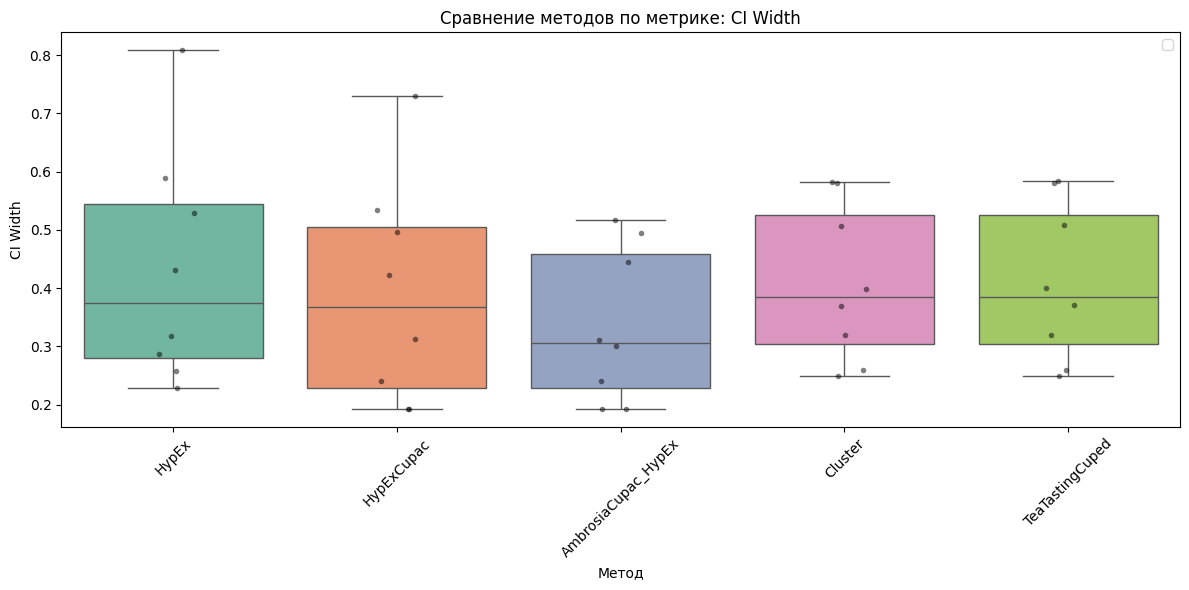

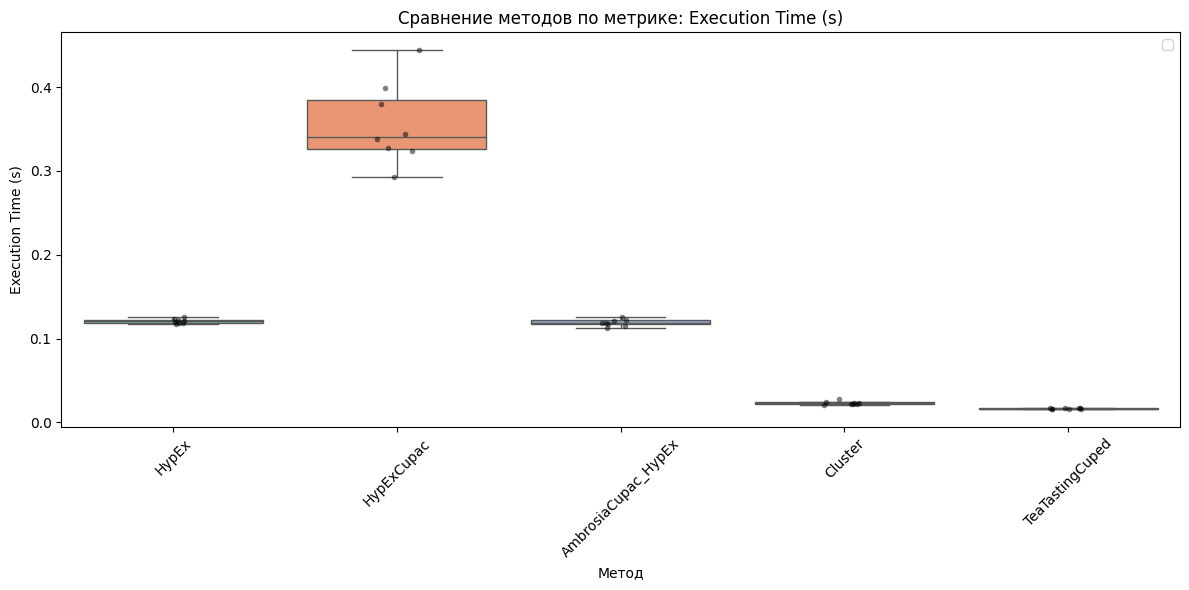

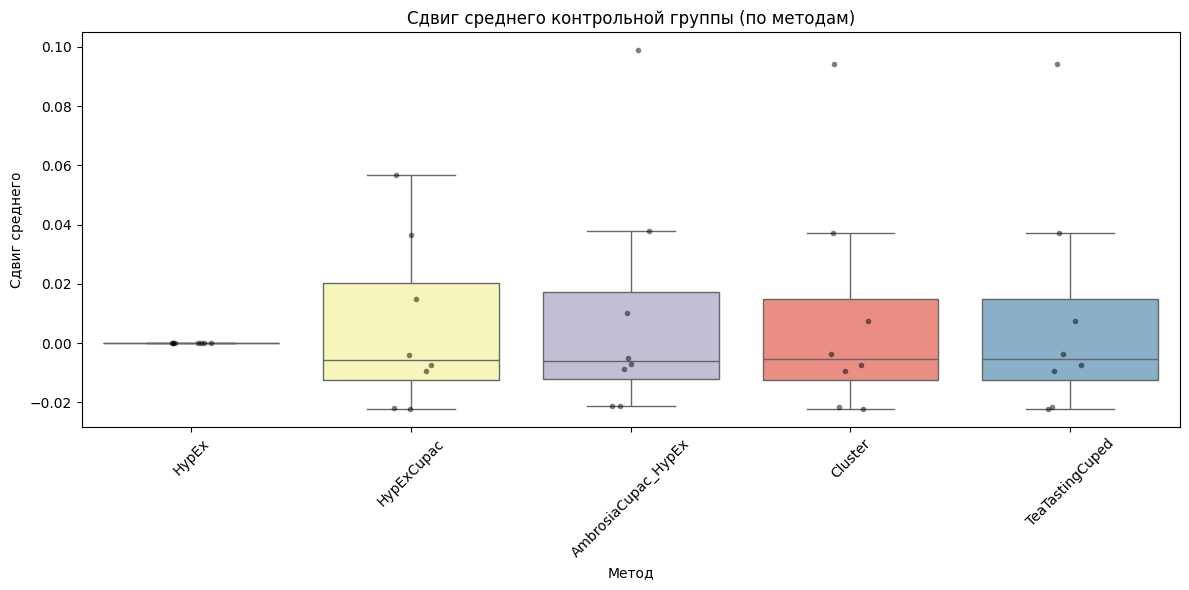

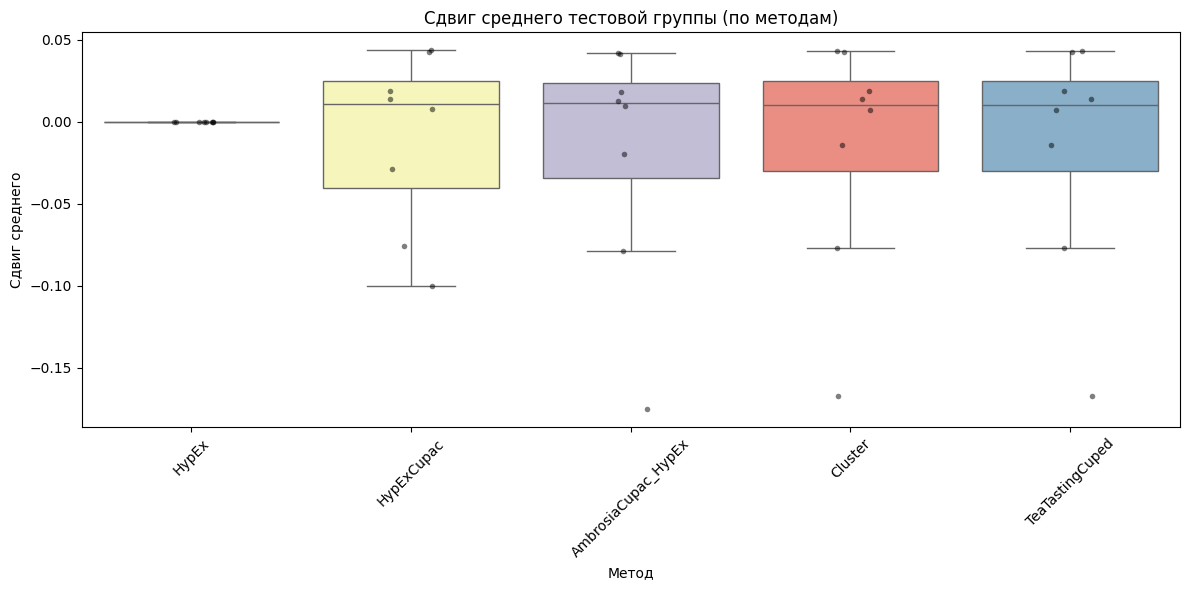

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = GLOBAL_RESULTS.copy()

metrics = {
    "ate ci delt": "CI Width",
    "execution time (sec)": "Execution Time (s)"
}

for metric_col, metric_name in metrics.items():
    plt.figure(figsize=(12, 6))
    
    sns.boxplot(
        data=df,
        x="experiment",
        y=metric_col,
        showfliers=False,
        palette="Set2"
    )
    
    sns.stripplot(
        data=df,
        x="experiment",
        y=metric_col,
        color="black",
        size=4,
        alpha=0.5,
        jitter=True
    )

    plt.title(f"Сравнение методов по метрике: {metric_name}")
    plt.xlabel("Метод")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


for col, title in {
    "control means diff": "Сдвиг среднего контрольной группы",
    "test means diff": "Сдвиг среднего тестовой группы"
}.items():
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="experiment", y=col, palette="Set3", showfliers=False)
    sns.stripplot(data=df, x="experiment", y=col, color="black", size=4, alpha=0.5, jitter=True)
    plt.title(f"{title} (по методам)")
    plt.xlabel("Метод")
    plt.ylabel("Сдвиг среднего")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
